In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module_heliquest_like
from module_heliquest_like import amino_acids

In [25]:
# import
df_AH = pd.read_excel('SourceData/AH_sequences.xlsx')
df_NEES = pd.read_csv('Output/NEES_summary.csv')

In [26]:
# Create AH name column
df_AH['AH_name'] = df_AH['Protein_Name'] + '-' + df_AH['AH#'].astype(str)
df_AH['AH_name'] = df_AH['AH_name'].str.replace('-1', '')
# lowercase
df_AH['AH_name'] = df_AH['AH_name'].str.lower()

# lowercase
df_NEES['AH'] = df_NEES['AH'].str.lower()


# merge
df = pd.merge(df_AH, df_NEES, left_on='AH_name', right_on='AH', how='inner')
# drop some columns
df = df.drop(columns=['AH_name', 'Protein_Name', 'AH#'])


# dropna
df = df.dropna(subset=['Median'])
df.reset_index(drop=True, inplace=True)

In [27]:
# AA composition analysis
for i, SEQ in enumerate(df.AA_seq.to_list()):
    aa_seq = module_heliquest_like.AA_seq(SEQ)

    aa_seq.calculate_hydrophobic_moment()
    aa_seq.extract_face_sequences()
    aa_seq.calculate_hydrophobicity()
    aa_seq.calculate_netcharge()
    aa_seq.calculate_dfactor()

    for AA in amino_acids:
        df.loc[i, 'phil_' + AA] = round(aa_seq.hydro_philic_face.count(AA) / len(aa_seq.hydro_philic_face), 2)
        df.loc[i, 'phob_' + AA] = round(aa_seq.hydro_phobic_face.count(AA) / len(aa_seq.hydro_philic_face), 2)
   
    df.loc[i, 'Length'] = len(SEQ)
    df.loc[i, 'Hydrophobicity'] = round(aa_seq.mean_hydrophobicity, 3)    
    df.loc[i, 'H_moment'] = aa_seq.mean_hydrophobic_moment
    df.loc[i, 'Netcharge'] = round(aa_seq.netcharge, 3)
    df.loc[i, 'Dfactor'] = round(aa_seq.dfactor, 3)

In [28]:
# Subgrouping amino acids
df['phil_S_T'] = df['phil_S'] + df['phil_T']
df['phil_R_K'] = df['phil_R'] + df['phil_K']
df['phil_L_I'] = df['phil_L'] + df['phil_I']
df['phil_F_W_Y'] = df['phil_F'] + df['phil_W'] + df['phil_Y']
df['phil_M_C'] = df['phil_M'] + df['phil_C']
df['phil_D_E'] = df['phil_D'] + df['phil_E']
df['phil_N_Q'] = df['phil_N'] + df['phil_Q']

df['phob_S_T'] = df['phob_S'] + df['phob_T']
df['phob_R_K'] = df['phob_R'] + df['phob_K']
df['phob_L_I'] = df['phob_L'] + df['phob_I']
df['phob_F_W_Y'] = df['phob_F'] + df['phob_W'] + df['phob_Y']
df['phob_M_C'] = df['phob_M'] + df['phob_C']
df['phob_D_E'] = df['phob_D'] + df['phob_E']
df['phob_N_Q'] = df['phob_N'] + df['phob_Q']

In [29]:
# ST:RK ratio with decimal points 3
df["STRK_ratio"] = (df['phil_S_T'] / df['phil_R_K']).round(3)
# take log1p
df["STRK_ratio_Log1p"] = df["STRK_ratio"].apply(lambda x: round(np.log1p(x), 3))

In [30]:
# A bespoke funtion for plotting
def myplot(df, y):
    plt.figure(figsize=(3, 3))
    sns.boxplot(y=y, data=df, palette="Blues")
    # Add scatter points jittered for better visualization
    sns.stripplot(y=y, data=df, color="black", jitter=True, alpha=0.5)
    # sns.stripplot(x=x, y=y, data=df, order=order, color='black', jitter=True, alpha=0.5)

    plt.tight_layout()
    plt.show()

/var/folders/qv/j3ddjz6j0qq0nh7cbqghj4wh0000gn/T/ipykernel_6651/456037263.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=y, data=df, palette="Blues")


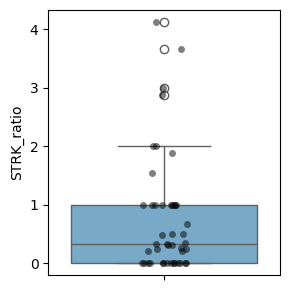

In [31]:
myplot(df, 'STRK_ratio')

/var/folders/qv/j3ddjz6j0qq0nh7cbqghj4wh0000gn/T/ipykernel_6651/456037263.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=y, data=df, palette="Blues")


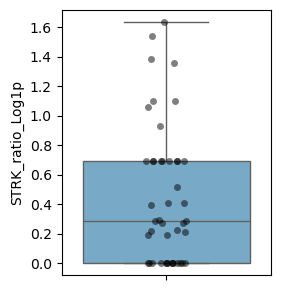

In [32]:
myplot(df, 'STRK_ratio_Log1p')

In [33]:
df.to_csv('Output/NEES_summary_with_heliquest.csv', index=False)